<a href="https://colab.research.google.com/github/druvz/NoShow/blob/main/predicting_no_shows_at_medical_appointments_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Data

In [3]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
url = 'https://raw.githubusercontent.com/druvz/NoShow/main/KaggleV2-May-2016.csv'
df = pd.read_csv(url)



In [4]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Descriptive Summary

In [6]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


## Number of Rows and Columns

The original dataset has 110,527 records and 14 features (input variables)

## Column Names

In [7]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

## Target Variable


No     88208
Yes    22319
Name: No-show, dtype: int64
Percent who didn't show up to their appointment: 20.193255946510806


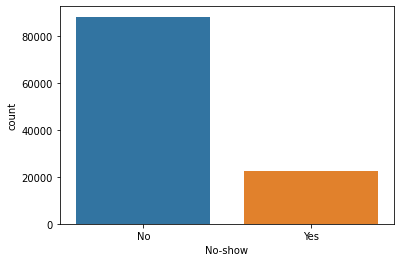

In [8]:
no_show = df["No-show"].value_counts()
print(no_show)

Percent_no_show = no_show["Yes"]/ no_show.sum() * 100
print("Percent who didn't show up to their appointment:",Percent_no_show )

sns.countplot(df['No-show'])


## Recode Target Variable
0 =  Did not show up to appointment

1 =  Showed up to appointment

In [9]:
df['No-show'].replace("No", 0,inplace=True)
df['No-show'].replace("Yes", 1,inplace=True)


Remove invalid Age

In [10]:

df=df[~df["Age"] < 0]


## Exploratory Analysis on Features


General Distribution

Text(0.5, 1.0, 'Handcap Distribution')

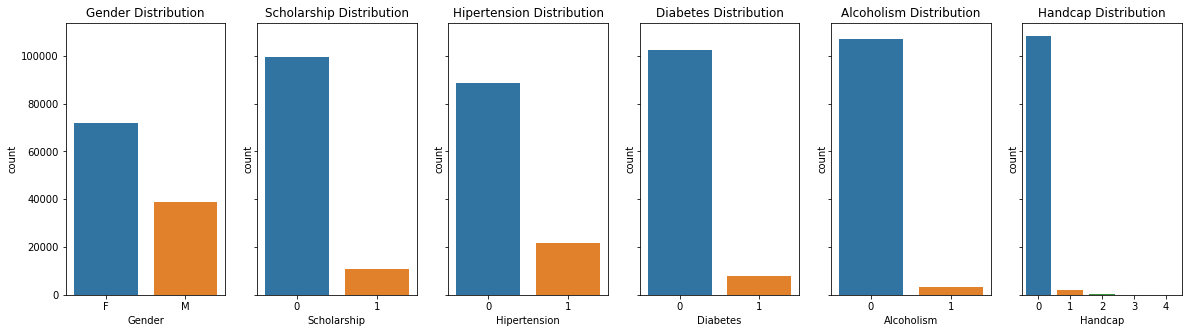

In [11]:
fig, axes = plt.subplots(1, 6, figsize=(20, 5), sharey=True)
sns.countplot(df['Gender'],ax=axes[0])
axes[0].set_title("Gender Distribution")

sns.countplot(df['Scholarship'],ax=axes[1])
axes[1].set_title("Scholarship Distribution")

sns.countplot(df['Hipertension'],ax=axes[2])
axes[2].set_title("Hipertension Distribution")

sns.countplot(df['Diabetes'],ax=axes[3])
axes[3].set_title("Diabetes Distribution")

sns.countplot(df['Alcoholism'],ax=axes[4])
axes[4].set_title("Alcoholism Distribution")

sns.countplot(df['Handcap'],ax=axes[5])
axes[5].set_title("Handcap Distribution")

Split Age to Bins

In [12]:
bins=[-1,0,2,10,20,30,40,50,60,80,100,200]
labels=['0-2','2-10','10-20','20-30','30-40','40-50','50-60','60-80','80-100','100+']
df['Age_Bins']=pd.cut(df['Age'],bins)

In [13]:
df.loc[df['Age']>100,['Age','Age_Bins']]

,Age,Age_Bins
58014,102,"(100, 200]"
63912,115,"(100, 200]"
63915,115,"(100, 200]"
68127,115,"(100, 200]"
76284,115,"(100, 200]"
90372,102,"(100, 200]"
97666,115,"(100, 200]"


Age Distribution

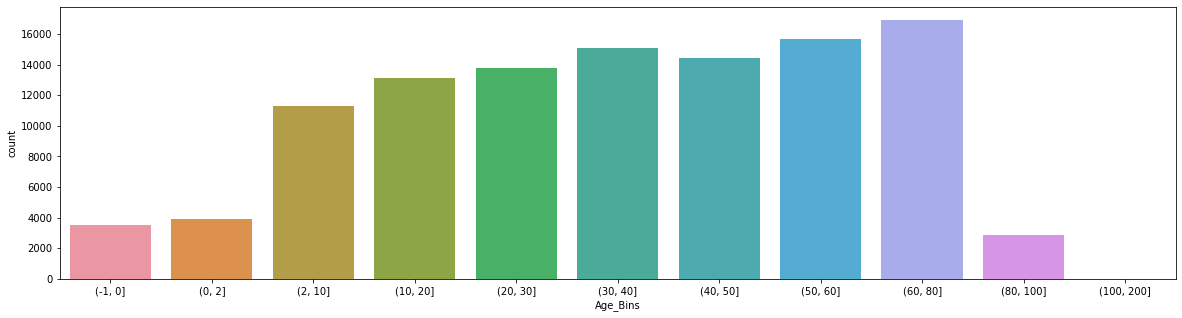

In [14]:
plt.rcParams['figure.figsize']=20,5
sns.countplot(df["Age_Bins"])

No Show vs Age

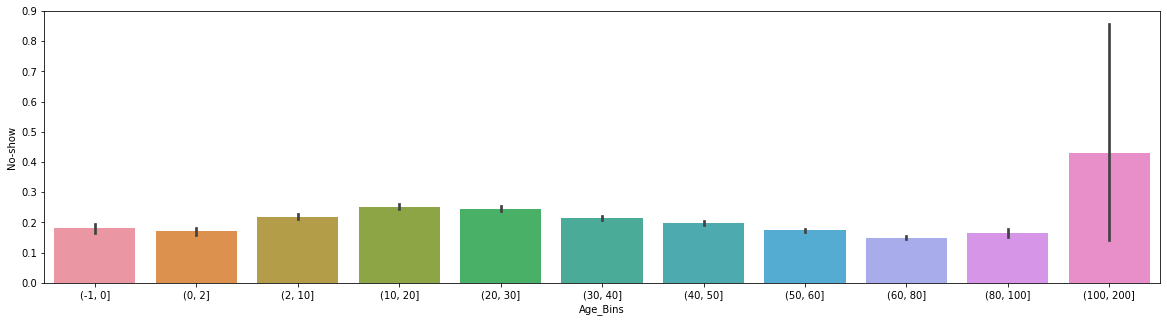

In [15]:
plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x="Age_Bins", data=df )

# blackline need to check

Handicap

In [16]:
#Convert to Categorical
# NOte: Run one time only



df['Handcap'] = pd.Categorical(df['Handcap'])
#Convert to Dummy Variables
Handicap = pd.get_dummies(df['Handcap'], prefix = 'Handicap')
df = pd.concat([df, Handicap], axis=1)


In [17]:
## See how each type of handicap affects whether a patient will show up to an appointment 
handicaps = ["Handicap_1", "Handicap_2", "Handicap_3", "Handicap_4"]
for h in handicaps:
    print(df.groupby(h)['No-show'].mean())
    

Handicap_1
0    0.202362
1    0.179236
Name: No-show, dtype: float64
Handicap_2
0    0.201934
1    0.202186
Name: No-show, dtype: float64
Handicap_3
0    0.201931
1    0.230769
Name: No-show, dtype: float64
Handicap_4
0    0.201931
1    0.333333
Name: No-show, dtype: float64


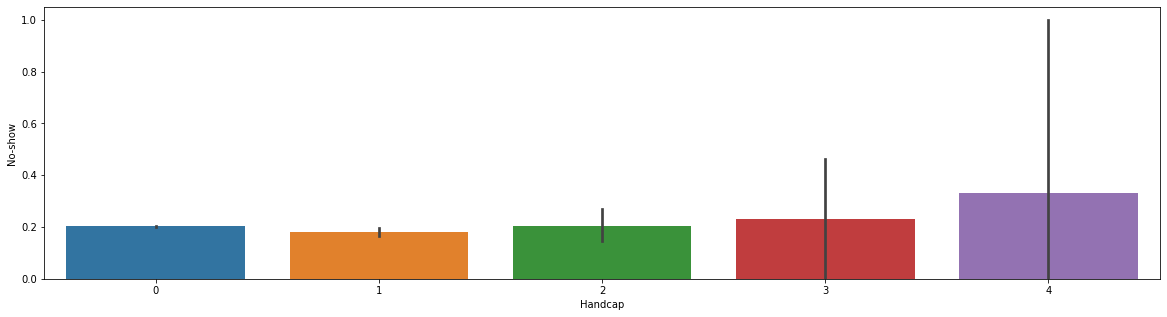

In [18]:
sns.barplot(df['Handcap'],y=df['No-show'])

In [19]:
df.loc[df.Age_Bins.isnull()==True,['Age','Age_Bins']].head(100)


,Age,Age_Bins


## Feature Engineering

Wait Days before appointment

In [20]:
df['AppointmentDateTime']=df['AppointmentDay'].str[:-1].str.replace("T"," ")
df['ScheduledDateTime']=df['ScheduledDay'].str[:-1].str.replace("T"," ")

In [21]:
df['AppointmentDateTime']=pd.to_datetime(df['AppointmentDateTime'])
df['AppointmentDate']=df['AppointmentDateTime'].dt.date
df['ScheduledDateTime']=pd.to_datetime(df['ScheduledDateTime'])
df['ScheduledDate']=df['ScheduledDateTime'].dt.date

In [22]:
#df[['AppointmentDateTime','ScheduledDateTime']]
df.dtypes

PatientId                     float64
AppointmentID                   int64
Gender                         object
ScheduledDay                   object
AppointmentDay                 object
Age                             int64
Neighbourhood                  object
Scholarship                     int64
Hipertension                    int64
Diabetes                        int64
Alcoholism                      int64
Handcap                      category
SMS_received                    int64
No-show                         int64
Age_Bins                     category
Handicap_0                      uint8
Handicap_1                      uint8
Handicap_2                      uint8
Handicap_3                      uint8
Handicap_4                      uint8
AppointmentDateTime    datetime64[ns]
ScheduledDateTime      datetime64[ns]
AppointmentDate                object
ScheduledDate                  object
dtype: object

#### Wait Days
In my experience, if I schedule an appointment far in advance and no one reminds me, I tend to forget about it. Or by the time my appointment day arrives, I feel better and don't bother showing up. In this section, I will create a variable called "wait_days" to see if the time between the date an appointment was scheduled and the date was the appointment is,  has an affect on no-shows.

In [23]:
df["Wait_days"] = (df["AppointmentDate"] - df["ScheduledDate"]).dt.days
df[['Wait_days','AppointmentDateTime','ScheduledDateTime']]
df['ScheduledTime']=df["ScheduledDateTime"].dt.time
df['Scheduledyr']=df["ScheduledDateTime"].dt.year
df['ScheduledDayOfWeek']=df["ScheduledDateTime"].dt.day_name()

In [24]:
df.loc[df['Wait_days']<0,['Wait_days','ScheduledDateTime','AppointmentDateTime']]

,Wait_days,ScheduledDateTime,AppointmentDateTime
27033,-1,2016-05-10 10:51:53,2016-05-09
55226,-1,2016-05-18 14:50:41,2016-05-17
64175,-1,2016-05-05 13:43:58,2016-05-04
71533,-6,2016-05-11 13:49:20,2016-05-05
72362,-1,2016-05-04 06:50:57,2016-05-03


Remove above incorrect Data 

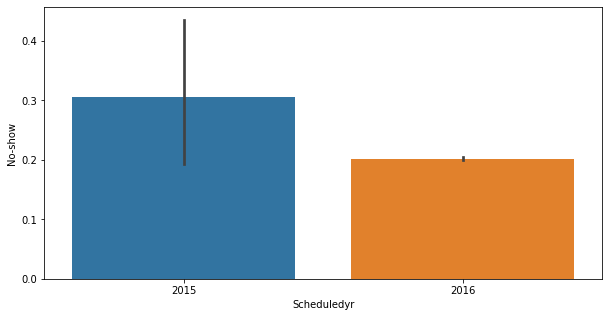

In [25]:
#df['Scheduledyr'].value_counts()

#df.plot.line(x='Scheduledyr', y=df.groupby('Scheduledyr')['No-show'].apply(lambda x:  x.sum()  ))
plt.rcParams['figure.figsize']=10,5
sns.barplot(y="No-show", x="Scheduledyr",data=df )

In [26]:
df.shape

(110526, 28)

In [27]:
df=df[df['Wait_days']>=0]

In [28]:
df.shape

(110521, 28)

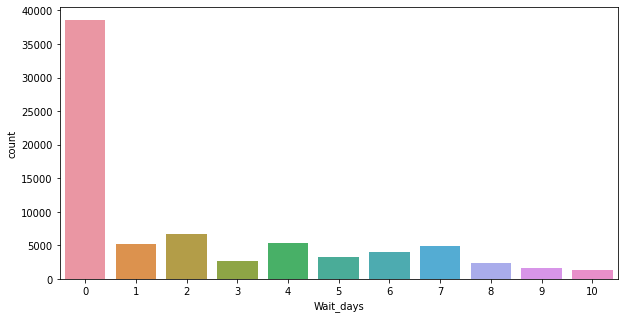

In [29]:
wait=pd.DataFrame(df.loc[df['Wait_days']<11 , ['Wait_days'] ])
sns.countplot(wait['Wait_days'])


In [30]:
#df.loc[df['Wait_days']==3,['Wait_days','AppointmentDateTime','ScheduledDateTime']]

In [31]:
df['is_weekend']=df['ScheduledDayOfWeek'].apply(lambda x: 1 if x in ('Saturday','Sunday') else 0)

Weekend vs No show 

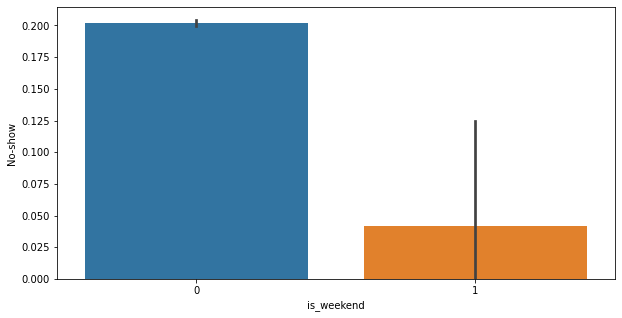

In [32]:

plt.rcParams['figure.figsize']=10,5
sns.barplot(y="No-show", x="is_weekend",data=df )

No Show vs weekend vs Age

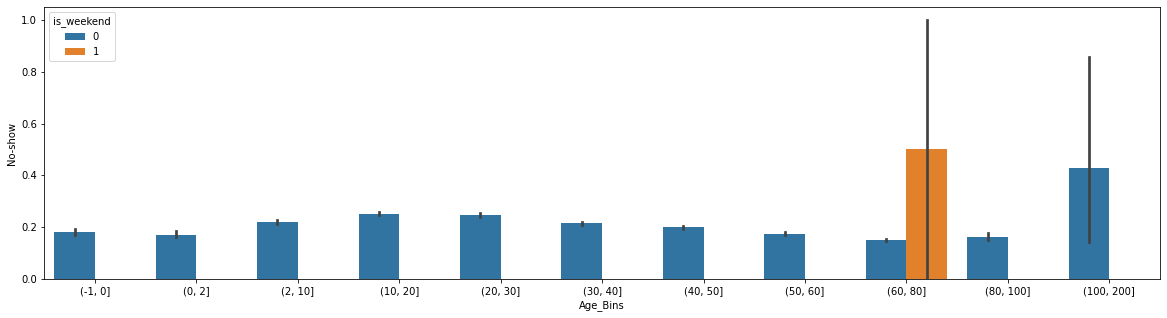

In [33]:

plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x='Age_Bins',hue="is_weekend",data=df )

Binning Wait Days

In [34]:
bins=[-1,0,1,2,3,7,14,30,60,90,1000]

df['Wait_days_Bins']=pd.cut(df['Wait_days'],bins)

In [35]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'Age_Bins', 'Handicap_0', 'Handicap_1', 'Handicap_2', 'Handicap_3',
       'Handicap_4', 'AppointmentDateTime', 'ScheduledDateTime',
       'AppointmentDate', 'ScheduledDate', 'Wait_days', 'ScheduledTime',
       'Scheduledyr', 'ScheduledDayOfWeek', 'is_weekend', 'Wait_days_Bins'],
      dtype='object')

Wait Days between Scheduled and Appointment 

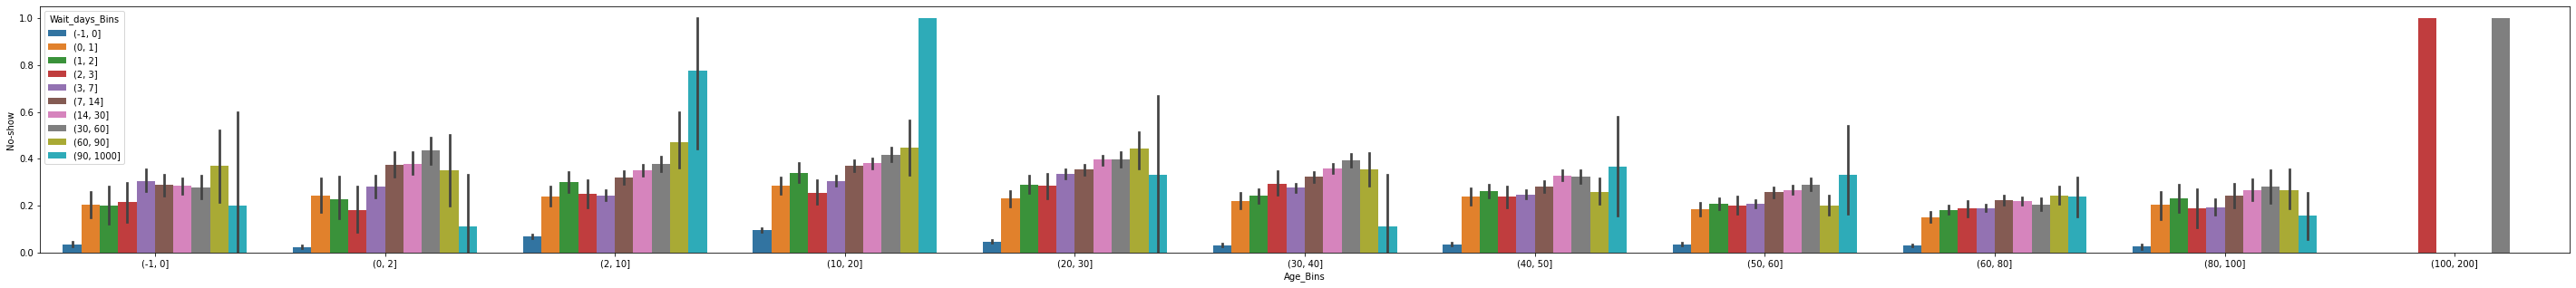

In [36]:

plt.rcParams['figure.figsize']=50,5
sns.barplot(y="No-show", x="Age_Bins", hue="Wait_days_Bins",data=df )

Wait Days vs Gender vs No Show Rate

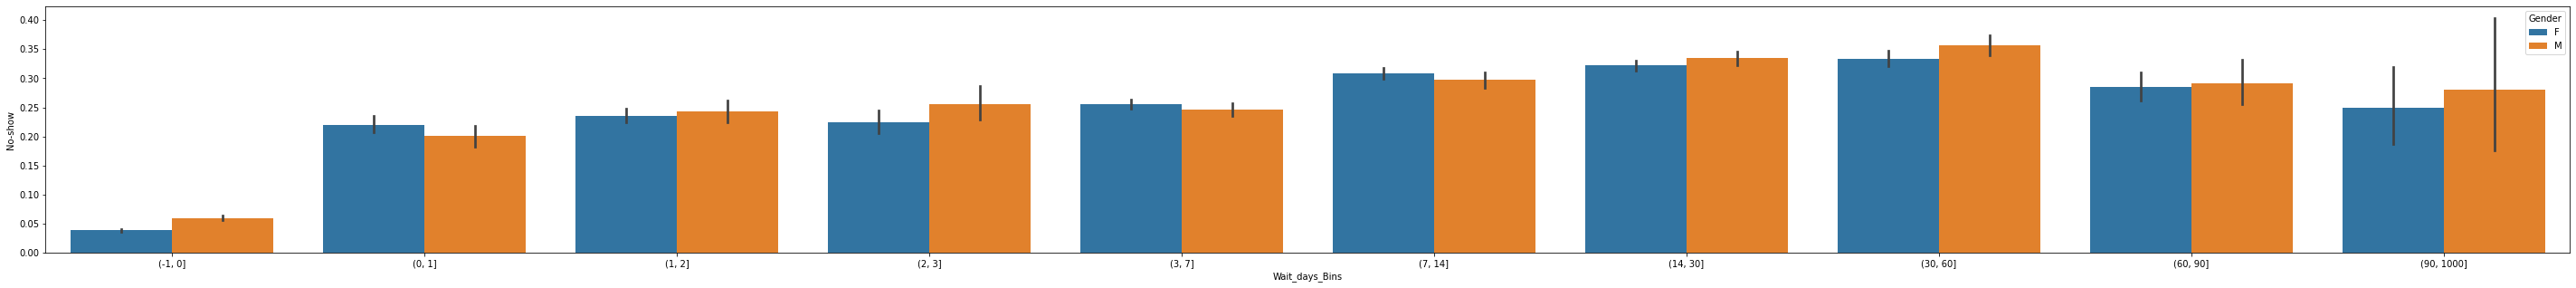

In [37]:

plt.rcParams['figure.figsize']=50,5
sns.barplot(y="No-show", x="Wait_days_Bins", hue="Gender",data=df )

Visiting Days vs No-Show Rate vs Age

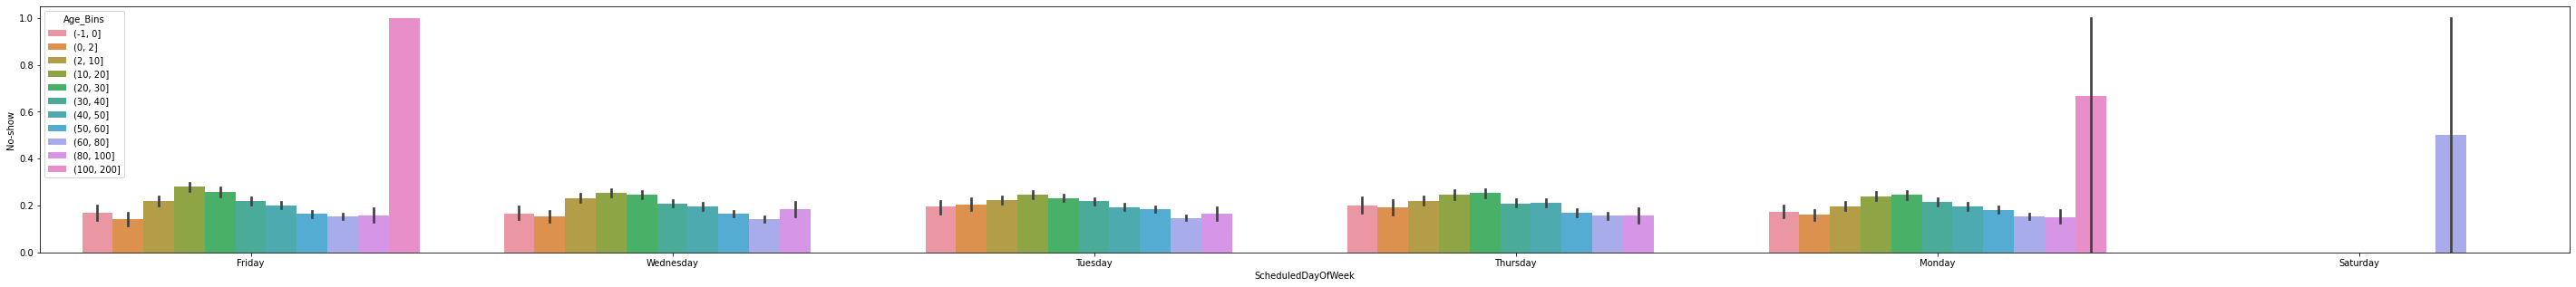

In [38]:
plt.rcParams['figure.figsize']=50,5
sns.barplot(y="No-show", hue="Age_Bins", x="ScheduledDayOfWeek",data=df )

In [39]:
df['ScheduledTime']=df["ScheduledDateTime"].dt.time
df['ScheduledHrs']=df["ScheduledDateTime"].dt.hour


In [40]:
bins=[-1,0,2,4,6,8,10,12,14,16,18,20,22,24]
#labels=['0-2','2-5','5-8','20-30','30-40','40-50','50-60','60-80','80-100','100+']
df['Scheduled_Hr_Bins']=pd.cut(df['ScheduledHrs'],bins)

In [41]:
df[['Scheduled_Hr_Bins','ScheduledHrs','ScheduledTime']]

,Scheduled_Hr_Bins,ScheduledHrs,ScheduledTime
0,"(16, 18]",18,18:38:08
1,"(14, 16]",16,16:08:27
2,"(14, 16]",16,16:19:04
3,"(16, 18]",17,17:29:31
4,"(14, 16]",16,16:07:23
...,...,...,...
110522,"(8, 10]",9,09:15:35
110523,"(6, 8]",7,07:27:33
110524,"(14, 16]",16,16:03:52
110525,"(14, 16]",15,15:09:23


Plotting Peak Scheduled Hours

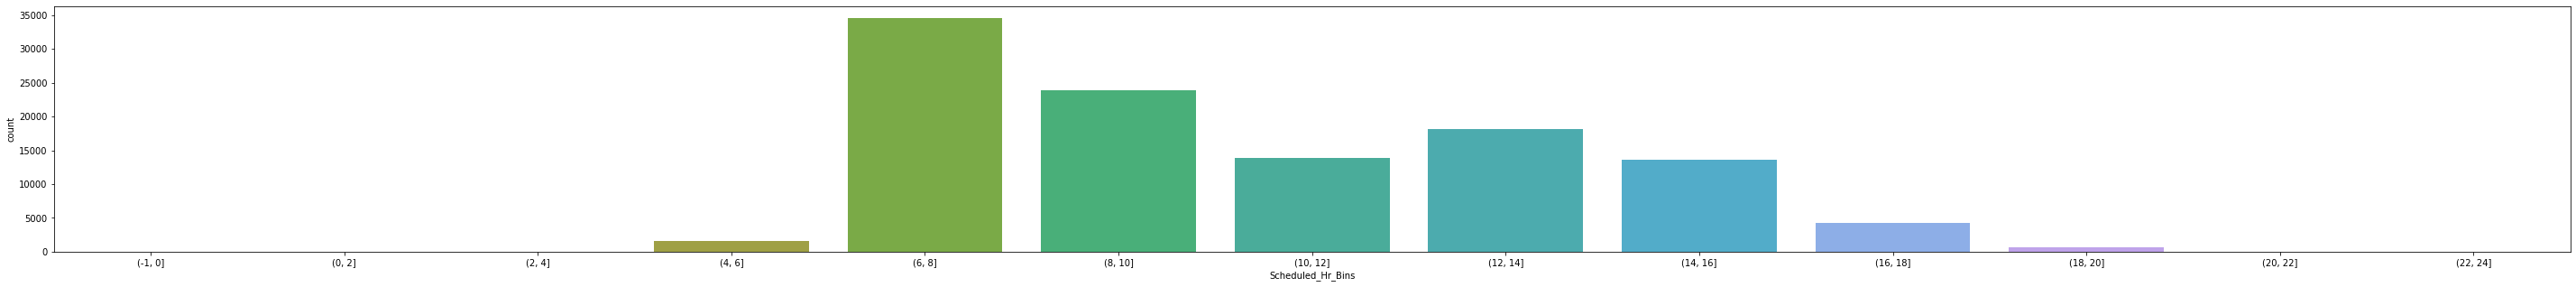

In [42]:
sns.countplot(df['Scheduled_Hr_Bins'])

Scheduled Hours vs No-Show Rate vs Age

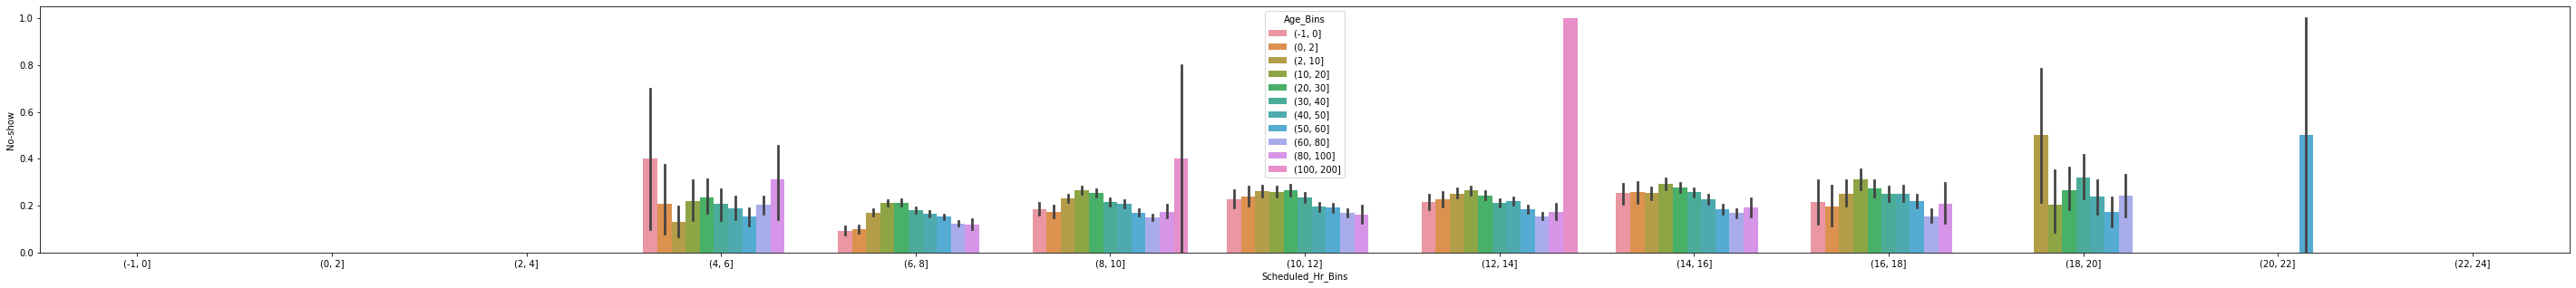

In [43]:
plt.rcParams['figure.figsize']=50,5
sns.barplot(y="No-show", x="Scheduled_Hr_Bins", hue="Age_Bins",data=df )

No-Show Rate vs Scheduled Hours 

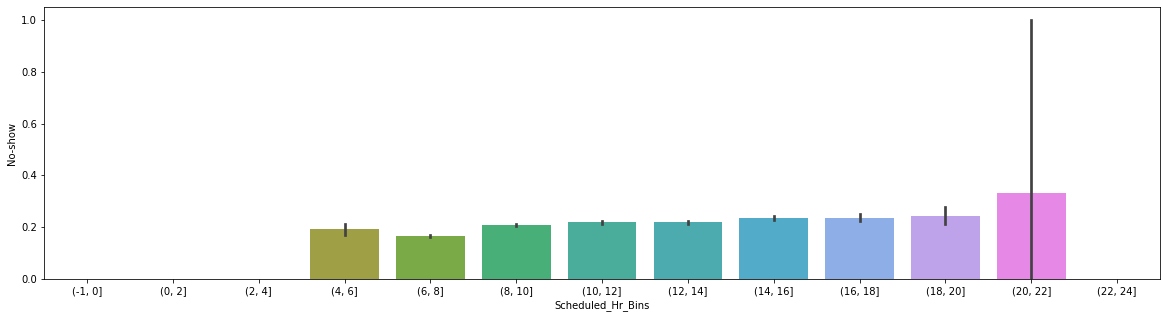

In [44]:
plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x="Scheduled_Hr_Bins",data=df )

Age vs No SHow vs Handicap

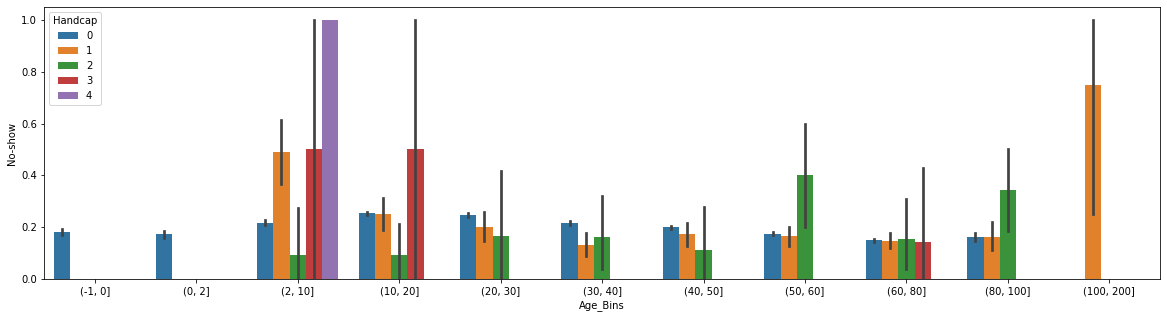

In [45]:
plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x="Age_Bins", hue="Handcap",data=df )

In [46]:
df['comorbities']=df['Hipertension']+df['Diabetes']

Age vs No SHow vs comorbities

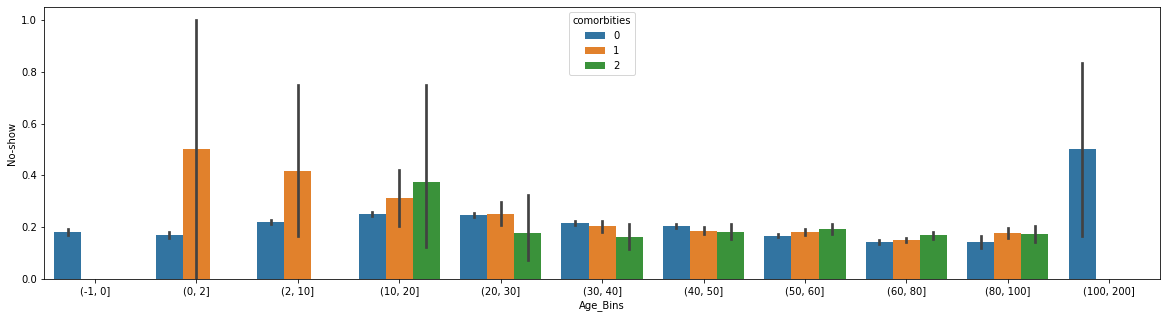

In [47]:
plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x="Age_Bins", hue="comorbities",data=df )

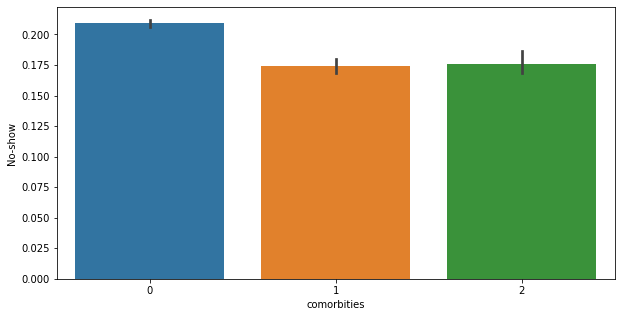

In [48]:
plt.rcParams['figure.figsize']=10,5
sns.barplot(y="No-show", x="comorbities",data=df )

Age vs No SHow vs Alcoholism

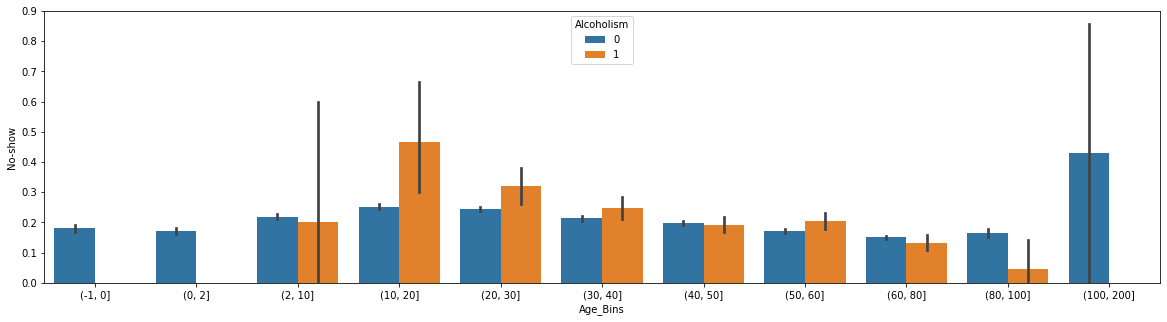

In [49]:
plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x="Age_Bins", hue="Alcoholism",data=df )

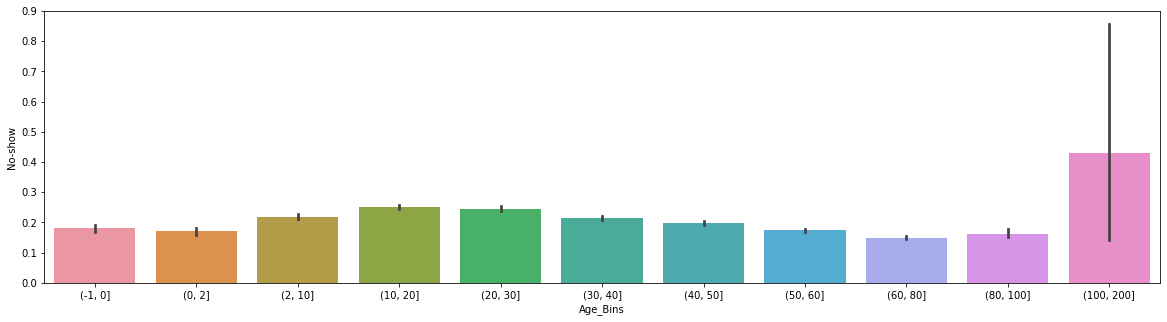

In [50]:
plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x="Age_Bins", data=df )

## Seeing how each feature relates to the target variable.


Gender
F    0.203115
M    0.199638
Name: No-show, dtype: float64
Hipertension
0    0.208995
1    0.173020
Name: No-show, dtype: float64
Alcoholism
0    0.201911
1    0.201488
Name: No-show, dtype: float64
Diabetes
0    0.203591
1    0.180033
Name: No-show, dtype: float64


Text(0.5, 1.0, 'Diabetes vs No-Show')

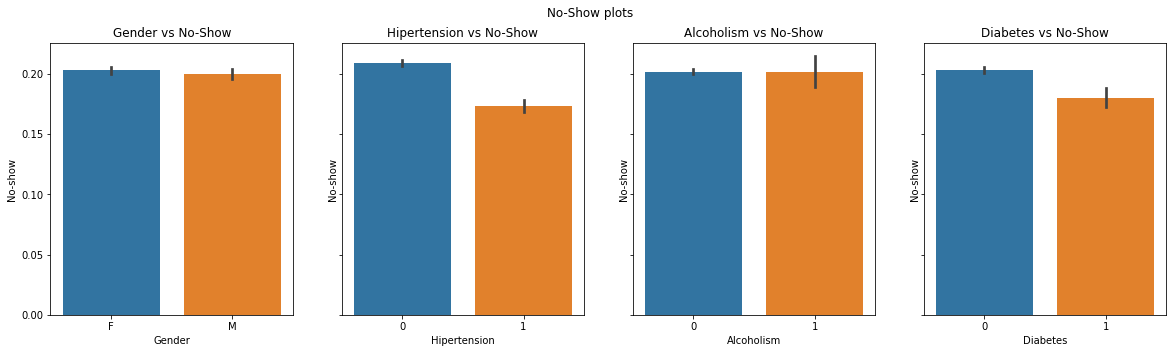

In [51]:
Exploratory_Analysis = ['Gender','Hipertension','Alcoholism','Diabetes']
for r in Exploratory_Analysis :
    print(df.groupby(r)['No-show'].mean())


fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.suptitle('No-Show plots')

# Gender
sns.barplot(ax=axes[0], x=df.Gender, y=df['No-show'])
axes[0].set_title("Gender vs No-Show")

# Hipertension
sns.barplot(ax=axes[1], x=df.Hipertension, y=df['No-show'])
axes[1].set_title("Hipertension vs No-Show")

# Alcoholism
sns.barplot(ax=axes[2], x=df.Alcoholism, y=df['No-show'])
axes[2].set_title("Alcoholism vs No-Show")

# Diabetes
sns.barplot(ax=axes[3], x=df.Diabetes, y=df['No-show'])
axes[3].set_title("Diabetes vs No-Show")



#df.groupby('Hipertension')['No-show'].mean().plot.bar()
#df.groupby('Alcoholism')['No-show'].mean().plot.bar()
#df.groupby('Diabetes')['No-show'].mean().plot.bar()
#df.groupby('Gender')['No-show'].mean().plot.bar()
#df.groupby(r)['No-show'].mean().plot.bar()

As shown above, gender does not seem to affect whether a person shows up to an appointment or not, as both males and females don't show up to approximately 20 percent of their appointments. Diabetes and Alcoholism don't seem to affect no-shows as well.

Hypertension seems to have a small affect, as a patient who has hypertension is 3% more likely to show up than a patient who doesn't have hyper tension.

In [52]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'Age_Bins', 'Handicap_0', 'Handicap_1', 'Handicap_2', 'Handicap_3',
       'Handicap_4', 'AppointmentDateTime', 'ScheduledDateTime',
       'AppointmentDate', 'ScheduledDate', 'Wait_days', 'ScheduledTime',
       'Scheduledyr', 'ScheduledDayOfWeek', 'is_weekend', 'Wait_days_Bins',
       'ScheduledHrs', 'Scheduled_Hr_Bins', 'comorbities'],
      dtype='object')

## Number of Appointments Missed in the Past aka Now show history
Since PatientId is available, I created a new variable that adds how many appointments the patient has missed in the past. 

In [55]:
df['Num_App_Missed'] = df.groupby('PatientId')['No-show'].apply(lambda x: x.cumsum())
#df['Total_Appts']=df.groupby('PatientId').apply(lambda x: x.sum())
df['Num_App_Missed_percent']=round(100*(df.groupby('PatientId')['No-show'].apply(lambda x:  x.cumsum()  ) / df.groupby('PatientId').cumcount() ),0)

In [54]:
d=df.groupby('PatientId')['Num_App_Missed_percent','Num_App_Missed']
#d.head()
f=df.loc[df['Num_App_Missed_percent'].isna()==True,['Num_App_Missed_percent','Num_App_Missed']]
#df['Num_App_Missed_percent'].apply(lambda x:  x.fillna(0) if x.isna()==True  )
df[df['Num_App_Missed_percent'].isna()==True]['Num_App_Missed_percent'].fillna(0,inplace=True)
#df[df['Num_App_Missed_percent'].isna()==True]

df['Num_App_Missed_percent'].fillna(0,inplace=True)
df[['Num_App_Missed_percent','Num_App_Missed']]

,Num_App_Missed_percent,Num_App_Missed
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
110522,100.0,1
110523,33.0,1
110524,0.0,0
110525,0.0,0


In [58]:

f=df.loc[df['Num_App_Missed_percent']=='inf',['Num_App_Missed_percent','Num_App_Missed']]
f.head(20)

,Num_App_Missed_percent,Num_App_Missed


In [62]:
bins=[-1,0,1,2,3,4,6,9,12,1000]
#labels=['0-2','2-5','5-8','20-30','30-40','40-50','50-60','60-80','80-100','100+']
df['Num_Prev_Appts_Missed']=pd.cut(df['Num_App_Missed'],bins)

In [60]:
bins=[-1,0,5,10,20,30,40,50,60,70,80,90,100]
#df['Num_App_Missed_per_range']=pd.cut(df['Num_App_Missed_percent'],bins)
df['Num_App_Missed_per_bin']=pd.cut(df['Num_App_Missed_percent'],bins)
#df['Num_App_Missed_percent'].value_counts()
#df.loc[df['Num_App_Missed_percent']==inf,['Num_App_Missed']]
df['Num_App_Missed_per_bin'].value_counts()

(-1, 0]      26730
(90, 100]     8624
(40, 50]      4050
(30, 40]      2219
(10, 20]      1268
(20, 30]      1148
(60, 70]       881
(70, 80]       342
(0, 5]         299
(5, 10]        298
(50, 60]       217
(80, 90]        75
Name: Num_App_Missed_per_bin, dtype: int64

In [63]:
#df.loc[df['Num_Prev_Appts_Missed'].isna()==True,['Num_App_Missed']]
df.loc[df['Num_App_Missed']==14,['Num_Prev_Appts_Missed','Num_App_Missed']]


,Num_Prev_Appts_Missed,Num_App_Missed
95276,"(12, 1000]",14
95289,"(12, 1000]",14
95297,"(12, 1000]",14
95339,"(12, 1000]",14


## Whether the patient received a text reminder


In [81]:
df.groupby('SMS_received')['No-show'].mean()

SMS_received
0    0.166980
1    0.275745
Name: No-show, dtype: float64

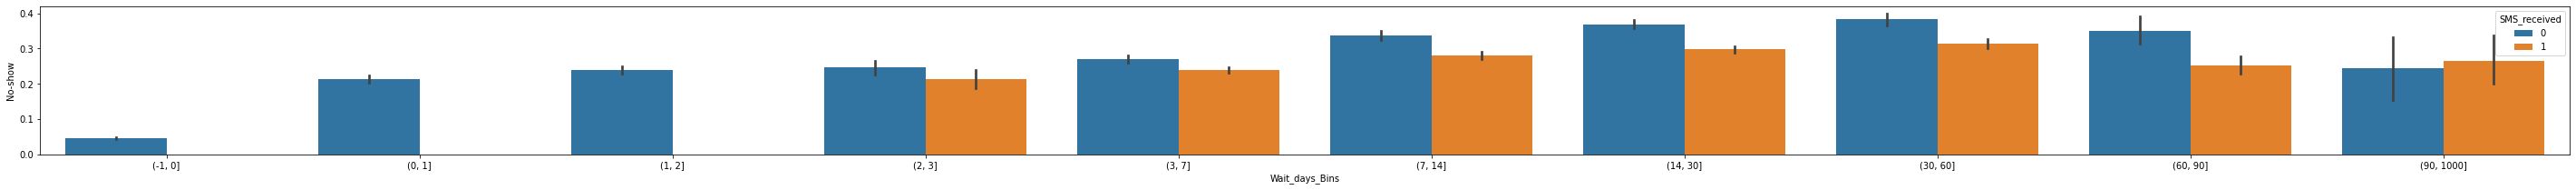

In [82]:
plt.rcParams['figure.figsize']=50,3
sns.barplot(y="No-show", hue="SMS_received",x="Wait_days_Bins",data=df )

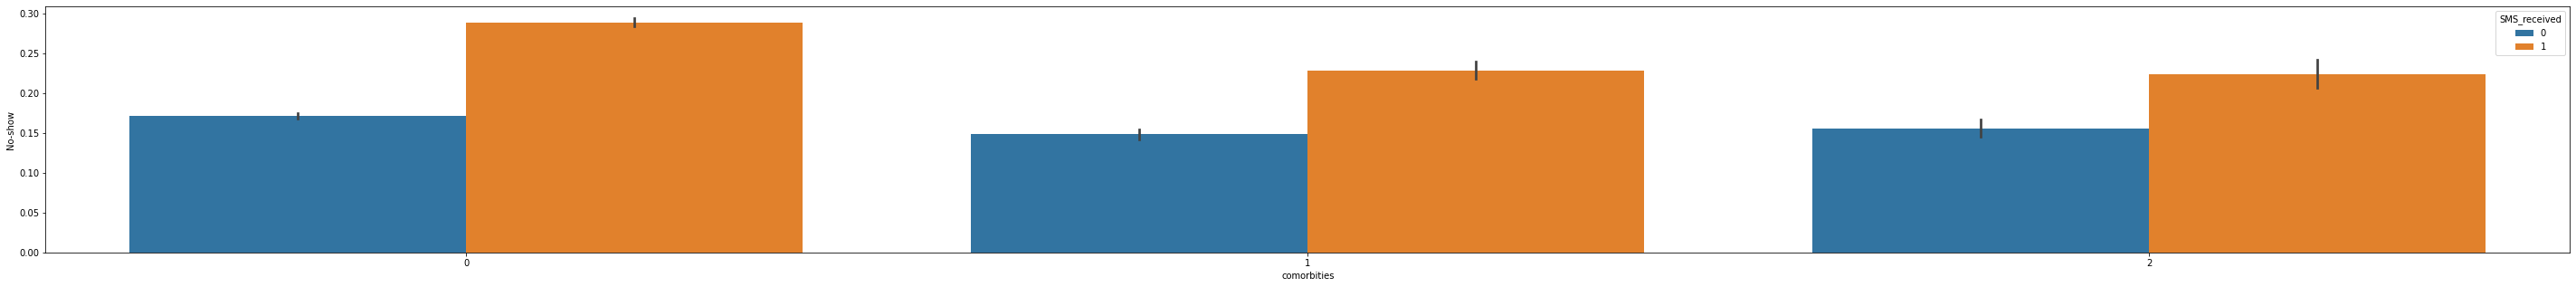

In [83]:
plt.rcParams['figure.figsize']=50,5
sns.barplot(y="No-show", hue="SMS_received",x="comorbities",data=df )

In [163]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'Age_Bins', 'Handicap_0', 'Handicap_1', 'Handicap_2', 'Handicap_3',
       'Handicap_4', 'AppointmentDateTime', 'ScheduledDateTime',
       'AppointmentDate', 'ScheduledDate', 'Wait_days', 'ScheduledTime',
       'ScheduledDayOfWeek', 'is_weekend', 'Wait_days_Bins', 'ScheduledHrs',
       'Scheduled_Hr_Bins', 'comorbities', 'Num_App_Missed',
       'Num_Prev_Appts_Missed'],
      dtype='object')

Unexpecedately, patients who received a text reminder did not show up to 27% person of their appointments, where as patients who did not receive a text reminder did not show up to 17% of their appointments

In [164]:
df[['Handicap_0','Handicap_1', 'Handicap_2', 'Handicap_3', 'Handicap_4']]

,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
110522,1,0,0,0,0
110523,1,0,0,0,0
110524,1,0,0,0,0
110525,1,0,0,0,0


In [68]:
li=['Gender','comorbities','is_weekend','Wait_days_Bins','SMS_received','Alcoholism','Age_Bins','Num_Prev_Appts_Missed','Scholarship','Scheduled_Hr_Bins','Num_App_Missed_per_bin']
#Handicap=df['Handicap_0','Handicap_1', 'Handicap_2', 'Handicap_3', 'Handicap_4']
df_dummies=pd.DataFrame()
for i in li:
  df[i] = pd.Categorical(df[i])
  #Convert to Dummy Variables
  Dumm = pd.get_dummies(df[i], prefix = i,drop_first=True)
  
  df_dummies = pd.concat([df_dummies, Dumm], axis=1)
  #df_dummies = pd.concat([df_dummies, Handicap], axis=1)

In [69]:
df_dummies.shape

(110521, 57)

In [80]:
No_show=df['No-show']

PatientId=df['PatientId']
df_dummies=pd.concat([df_dummies,No_show], axis=1)
df_dummies=pd.concat([df_dummies,PatientId], axis=1)


Handicap=df[['Handicap_0','Handicap_1', 'Handicap_2', 'Handicap_3', 'Handicap_4']]
df_dummies=pd.concat([df_dummies,Handicap], axis=1)

In [81]:
df_dummies.shape

(110521, 64)

In [70]:
df_dummies.columns

Index(['Gender_M', 'comorbities_1', 'comorbities_2', 'is_weekend_1',
       'Wait_days_Bins_(0, 1]', 'Wait_days_Bins_(1, 2]',
       'Wait_days_Bins_(2, 3]', 'Wait_days_Bins_(3, 7]',
       'Wait_days_Bins_(7, 14]', 'Wait_days_Bins_(14, 30]',
       'Wait_days_Bins_(30, 60]', 'Wait_days_Bins_(60, 90]',
       'Wait_days_Bins_(90, 1000]', 'SMS_received_1', 'Alcoholism_1',
       'Age_Bins_(0, 2]', 'Age_Bins_(2, 10]', 'Age_Bins_(10, 20]',
       'Age_Bins_(20, 30]', 'Age_Bins_(30, 40]', 'Age_Bins_(40, 50]',
       'Age_Bins_(50, 60]', 'Age_Bins_(60, 80]', 'Age_Bins_(80, 100]',
       'Age_Bins_(100, 200]', 'Num_Prev_Appts_Missed_(0, 1]',
       'Num_Prev_Appts_Missed_(1, 2]', 'Num_Prev_Appts_Missed_(2, 3]',
       'Num_Prev_Appts_Missed_(3, 4]', 'Num_Prev_Appts_Missed_(4, 6]',
       'Num_Prev_Appts_Missed_(6, 9]', 'Num_Prev_Appts_Missed_(9, 12]',
       'Num_Prev_Appts_Missed_(12, 1000]', 'Scholarship_1',
       'Scheduled_Hr_Bins_(0, 2]', 'Scheduled_Hr_Bins_(2, 4]',
       'Scheduled_H

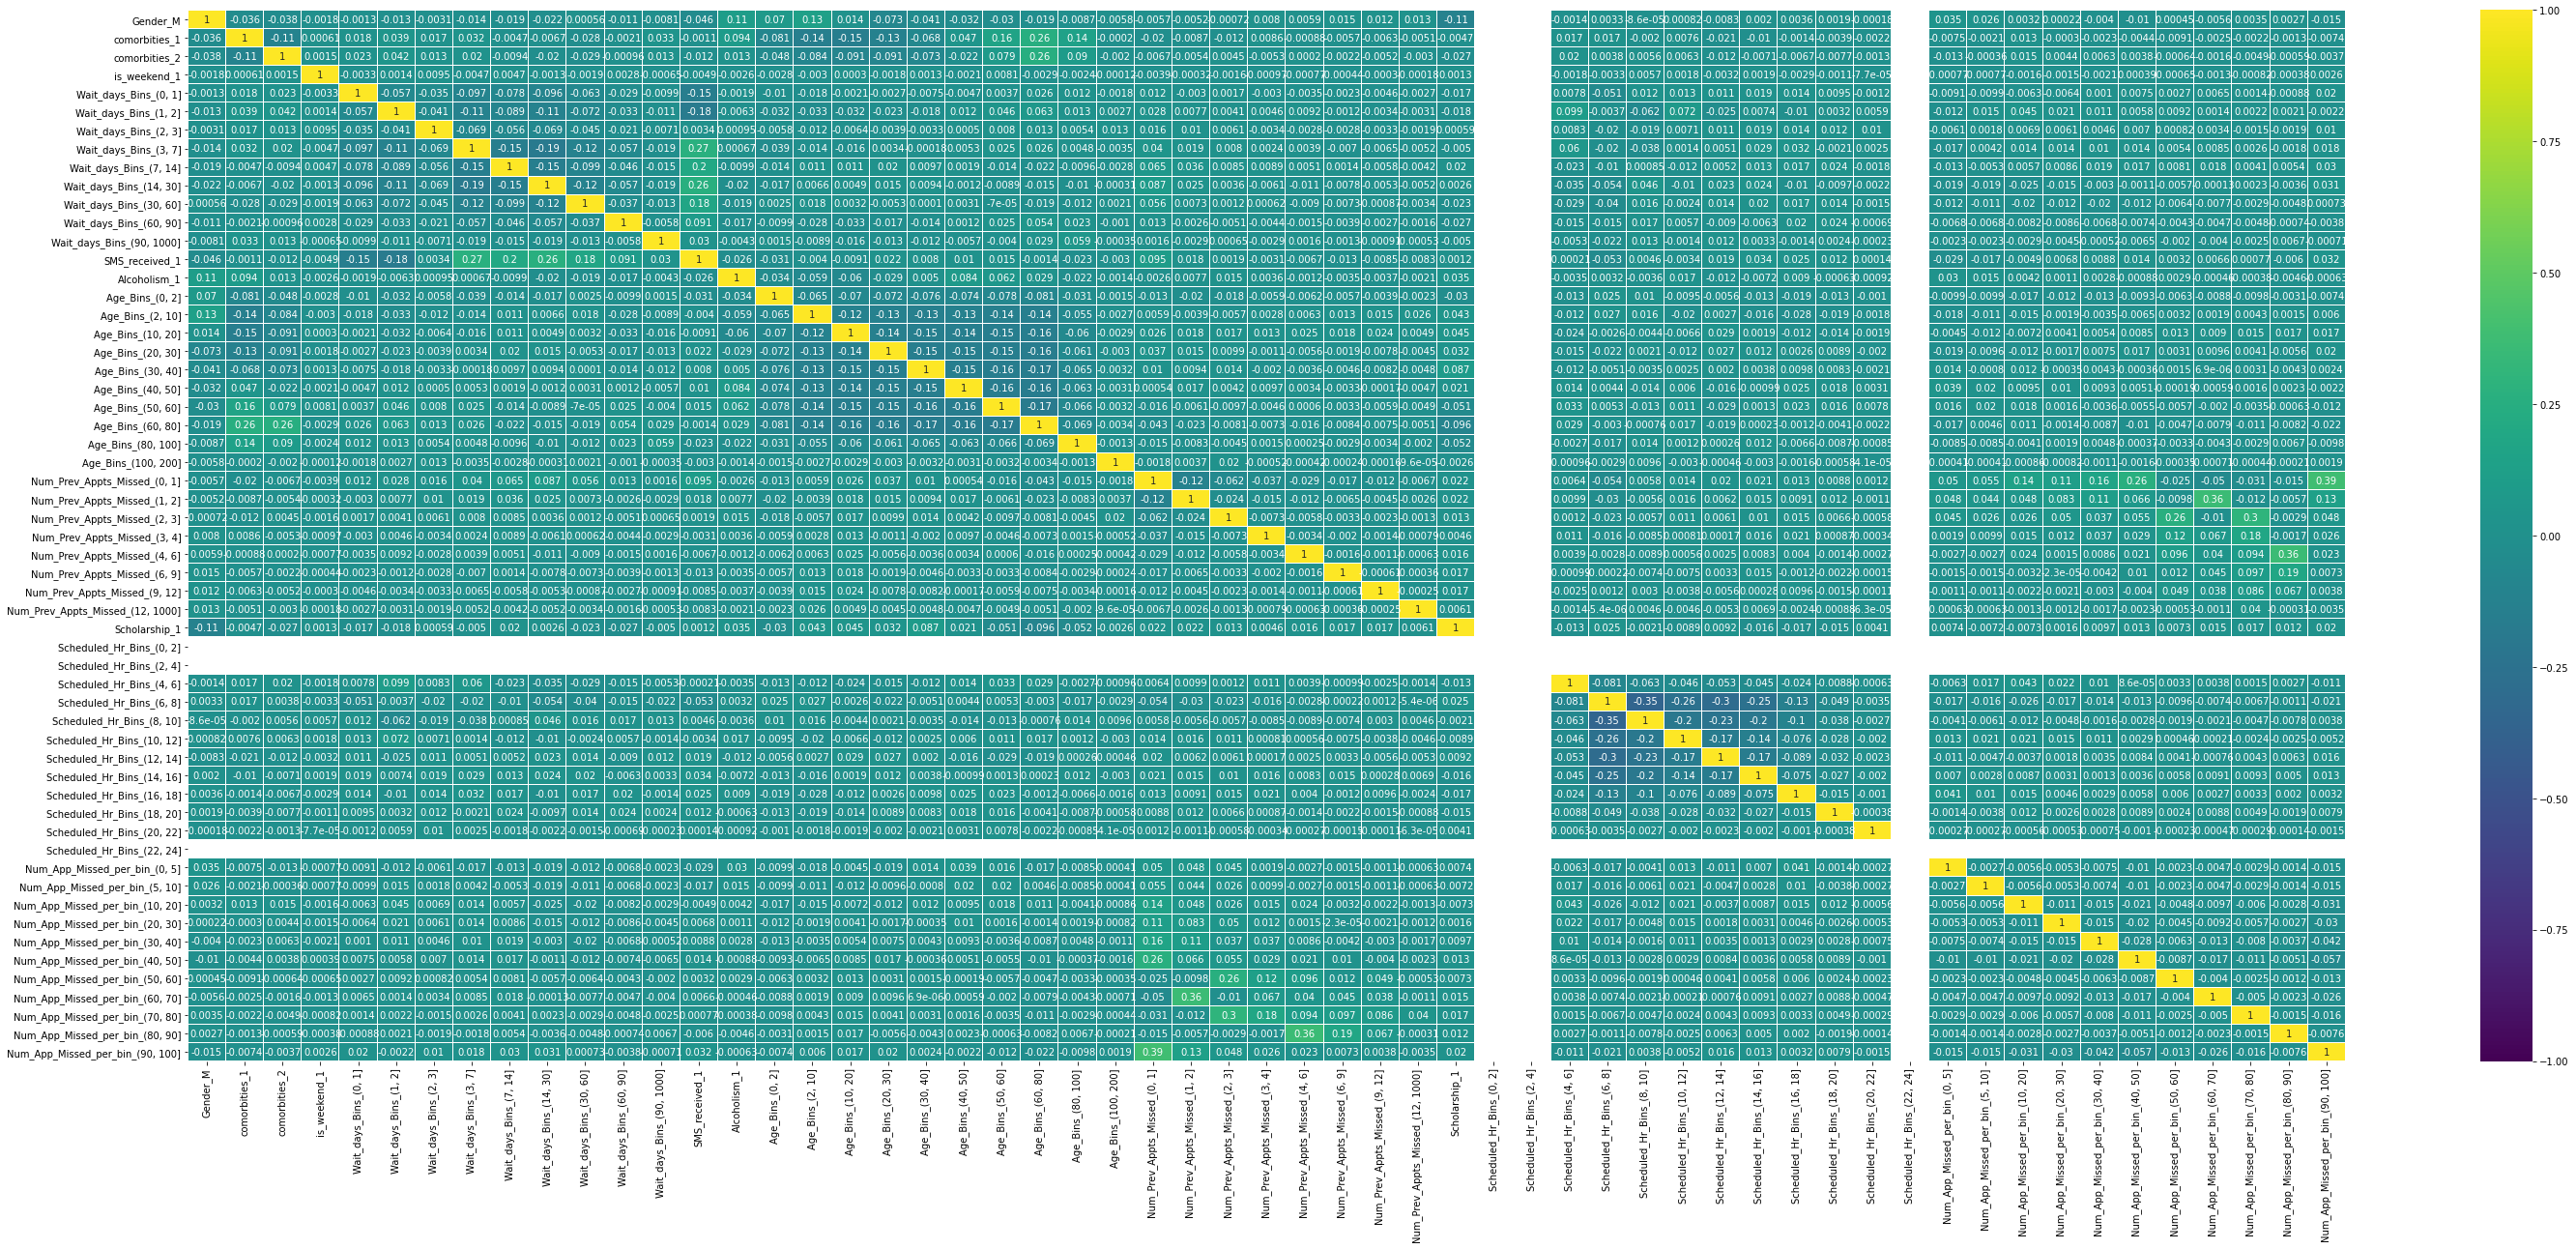

In [71]:


plt.figure(figsize = (50, 20))
sns.heatmap(df_dummies.corr(), vmin = -1, vmax = 1, cmap = "viridis", linewidths=0.01, annot=True)

In [171]:
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Age_Bins,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4,AppointmentDateTime,ScheduledDateTime,AppointmentDate,ScheduledDate,Wait_days,ScheduledTime,ScheduledDayOfWeek,is_weekend,Wait_days_Bins,ScheduledHrs,Scheduled_Hr_Bins,comorbities,Num_App_Missed,Num_Prev_Appts_Missed
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,"(60, 80]",1,0,0,0,0,2016-04-29,2016-04-29 18:38:08,2016-04-29,2016-04-29,0,18:38:08,Friday,0,"(-1, 0]",18,"(16, 18]",1,0,"(-1, 0]"
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0,"(50, 60]",1,0,0,0,0,2016-04-29,2016-04-29 16:08:27,2016-04-29,2016-04-29,0,16:08:27,Friday,0,"(-1, 0]",16,"(14, 16]",0,0,"(-1, 0]"


## Age


In [172]:
min_age = df.Age.min()
print("Min Age:", min_age)
max_age = df.Age.max()
print("Max Age:", max_age)


Min Age: 0
Max Age: 115


Due to the fact that minimum age is said to be -1, I will remove in the next line all records where age is < 0. I will also treat as outliers any age above a 100 due to the lack of people that live more than a 100 years.  

In [173]:
#df = df[(df.Age >= 0) & (df.Age <= 100)]

In [174]:
#import numpy as np

# Converts the two variables to datetime variables
#df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
#df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Create a variable called "AwaitingTime" by subtracting the date the patient made the appointment and the date of the appointment.
#df['AwaitingTime'] = df["AppointmentDay"].sub(df["ScheduledDay"], axis=0)

# Convert the result "AwaitingTime" to number of days between appointment day and scheduled day. 
#df["AwaitingTime"] = (df["AwaitingTime"] / np.timedelta64(1, 'D')).abs()


In [175]:
# Number of Appointments Missed by Patient
#df['Num_App_Missed'] = df.groupby('PatientId')['No-show'].apply(lambda x: x.cumsum())


## Let's take a look what columns we have after the feature engineering

In [176]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'Age_Bins', 'Handicap_0', 'Handicap_1', 'Handicap_2', 'Handicap_3',
       'Handicap_4', 'AppointmentDateTime', 'ScheduledDateTime',
       'AppointmentDate', 'ScheduledDate', 'Wait_days', 'ScheduledTime',
       'ScheduledDayOfWeek', 'is_weekend', 'Wait_days_Bins', 'ScheduledHrs',
       'Scheduled_Hr_Bins', 'comorbities', 'Num_App_Missed',
       'Num_Prev_Appts_Missed'],
      dtype='object')

In [177]:
df.dtypes

PatientId                       float64
AppointmentID                     int64
Gender                         category
ScheduledDay                     object
AppointmentDay                   object
Age                               int64
Neighbourhood                    object
Scholarship                    category
Hipertension                      int64
Diabetes                          int64
Alcoholism                     category
Handcap                        category
SMS_received                   category
No-show                           int64
Age_Bins                       category
Handicap_0                        uint8
Handicap_1                        uint8
Handicap_2                        uint8
Handicap_3                        uint8
Handicap_4                        uint8
AppointmentDateTime      datetime64[ns]
ScheduledDateTime        datetime64[ns]
AppointmentDate                  object
ScheduledDate                    object
Wait_days                         int64


Separate out numerical and categorical

In [72]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_categorical = df.select_dtypes(include=['object'])

In [73]:
print('Numerical Columns are {} '.format(df_numeric.columns))
print('Categorical Columns are {} '.format(df_categorical.columns))


Numerical Columns are Index(['PatientId', 'Num_App_Missed_percent'], dtype='object') 
Categorical Columns are Index(['ScheduledDay', 'AppointmentDay', 'Neighbourhood', 'AppointmentDate',
       'ScheduledDate', 'ScheduledTime', 'ScheduledDayOfWeek'],
      dtype='object') 


In [79]:
df_dummies.columns

Index(['Gender_M', 'comorbities_1', 'comorbities_2', 'is_weekend_1',
       'Wait_days_Bins_(0, 1]', 'Wait_days_Bins_(1, 2]',
       'Wait_days_Bins_(2, 3]', 'Wait_days_Bins_(3, 7]',
       'Wait_days_Bins_(7, 14]', 'Wait_days_Bins_(14, 30]',
       'Wait_days_Bins_(30, 60]', 'Wait_days_Bins_(60, 90]',
       'Wait_days_Bins_(90, 1000]', 'SMS_received_1', 'Alcoholism_1',
       'Age_Bins_(0, 2]', 'Age_Bins_(2, 10]', 'Age_Bins_(10, 20]',
       'Age_Bins_(20, 30]', 'Age_Bins_(30, 40]', 'Age_Bins_(40, 50]',
       'Age_Bins_(50, 60]', 'Age_Bins_(60, 80]', 'Age_Bins_(80, 100]',
       'Age_Bins_(100, 200]', 'Num_Prev_Appts_Missed_(0, 1]',
       'Num_Prev_Appts_Missed_(1, 2]', 'Num_Prev_Appts_Missed_(2, 3]',
       'Num_Prev_Appts_Missed_(3, 4]', 'Num_Prev_Appts_Missed_(4, 6]',
       'Num_Prev_Appts_Missed_(6, 9]', 'Num_Prev_Appts_Missed_(9, 12]',
       'Num_Prev_Appts_Missed_(12, 1000]', 'Scholarship_1',
       'Scheduled_Hr_Bins_(0, 2]', 'Scheduled_Hr_Bins_(2, 4]',
       'Scheduled_H

In [82]:
#100*(df.isna().sum()/len(df.index))
df.loc[df['Wait_days_Bins'].isna()==True,['AppointmentDateTime', 'ScheduledDateTime', 'Wait_days','Wait_days_Bins']]
#df_tmp[df_tmp['Wait_days']==-7]

#df.loc[df.Age_Bins.isnull()==True,['Age','Age_Bins']].head(100)

#import missingno as msno

#msno.bar(df)

,AppointmentDateTime,ScheduledDateTime,Wait_days,Wait_days_Bins


# Process Data to fit into models 

In [83]:


# Importing test_train_split from sklearn library
from sklearn.model_selection import train_test_split


y = df_dummies['No-show']
X = df_dummies.drop('No-show',axis=1)


In [183]:
#X.set_index('PatientId',inplace=True)

# Scale Data

The following explanation is from MachineLearningMastery.com and explains how this scaling works:
Standardization is a useful technique to transform attributes with a Gaussian distribution and differing means and standard deviations to a standard Gaussian distribution with a mean of 0 and a standard deviation of 1.
It is most suitable for techniques that assume a Gaussian distribution in the input variables and work better with rescaled data, such as linear regression, logistic regression and linear discriminate analysis.

In [184]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_std = scaler.fit_transform(X)
#cols=X.columns
#X_std=pd.DataFrame(X_std)
#X_std.columns=cols
#X_std.head()

## Split to train and test 

In [84]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [186]:
X_train.head()

,Gender_M,comorbities_1,comorbities_2,is_weekend_1,"Wait_days_Bins_(0, 1]","Wait_days_Bins_(1, 2]","Wait_days_Bins_(2, 3]","Wait_days_Bins_(3, 7]","Wait_days_Bins_(7, 14]","Wait_days_Bins_(14, 30]","Wait_days_Bins_(30, 60]","Wait_days_Bins_(60, 90]","Wait_days_Bins_(90, 1000]",SMS_received_1,Alcoholism_1,"Age_Bins_(0, 2]","Age_Bins_(2, 10]","Age_Bins_(10, 20]","Age_Bins_(20, 30]","Age_Bins_(30, 40]","Age_Bins_(40, 50]","Age_Bins_(50, 60]","Age_Bins_(60, 80]","Age_Bins_(80, 100]","Age_Bins_(100, 200]","Num_Prev_Appts_Missed_(0, 1]","Num_Prev_Appts_Missed_(1, 2]","Num_Prev_Appts_Missed_(2, 3]","Num_Prev_Appts_Missed_(3, 4]","Num_Prev_Appts_Missed_(4, 6]","Num_Prev_Appts_Missed_(6, 9]","Num_Prev_Appts_Missed_(9, 12]","Num_Prev_Appts_Missed_(12, 1000]",Scholarship_1,"Scheduled_Hr_Bins_(0, 2]","Scheduled_Hr_Bins_(2, 4]","Scheduled_Hr_Bins_(4, 6]","Scheduled_Hr_Bins_(6, 8]","Scheduled_Hr_Bins_(8, 10]","Scheduled_Hr_Bins_(10, 12]","Scheduled_Hr_Bins_(12, 14]","Scheduled_Hr_Bins_(14, 16]","Scheduled_Hr_Bins_(16, 18]","Scheduled_Hr_Bins_(18, 20]","Scheduled_Hr_Bins_(20, 22]","Scheduled_Hr_Bins_(22, 24]",PatientId,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4
25480,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.882323e+14,1,0,0,0,0
95273,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8.621964e+12,1,0,0,0,0
22559,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9.338197e+11,1,0,0,0,0
99213,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.114855e+11,1,0,0,0,0
14863,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5.884189e+12,1,0,0,0,0


Text(0.5, 1.0, 'Y_Test')

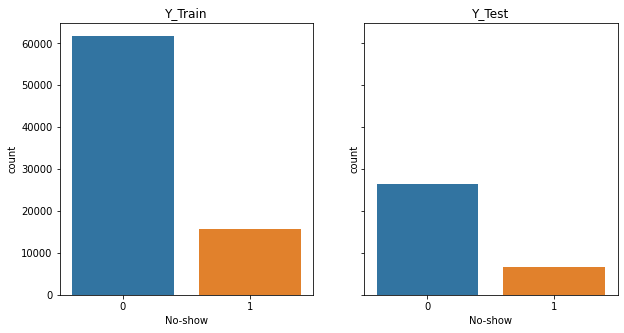

In [85]:
#plt.rcParams['figure.figsize']=5,5
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
#sns.countplot(df['Gender'],ax=axes[0])
sns.countplot(y_train,ax=axes[0])
axes[0].set_title("Y_Train")

sns.countplot(y_test,ax=axes[1])
axes[1].set_title("Y_Test")

#Data Imbalancing


In [86]:
import sklearn
from imblearn.over_sampling import SMOTE
sm = SMOTE()
cols=X_train.columns
#print(cols)
#patid=X_train['PatientID']
X_train_sm,y_train_sm= sm.fit_sample(X_train,y_train)
X_test_sm,y_test_sm= sm.fit_sample(X_test,y_test)
X_train_sm=pd.DataFrame(X_train_sm)
X_train_sm.columns=cols

X_test_sm=pd.DataFrame(X_test_sm)
X_test_sm.columns=cols

In [87]:
X_train_sm.set_index('PatientId',inplace=True)
X_test_sm.set_index('PatientId',inplace=True)

In [190]:
X_test_sm.head()

,Gender_M,comorbities_1,comorbities_2,is_weekend_1,"Wait_days_Bins_(0, 1]","Wait_days_Bins_(1, 2]","Wait_days_Bins_(2, 3]","Wait_days_Bins_(3, 7]","Wait_days_Bins_(7, 14]","Wait_days_Bins_(14, 30]","Wait_days_Bins_(30, 60]","Wait_days_Bins_(60, 90]","Wait_days_Bins_(90, 1000]",SMS_received_1,Alcoholism_1,"Age_Bins_(0, 2]","Age_Bins_(2, 10]","Age_Bins_(10, 20]","Age_Bins_(20, 30]","Age_Bins_(30, 40]","Age_Bins_(40, 50]","Age_Bins_(50, 60]","Age_Bins_(60, 80]","Age_Bins_(80, 100]","Age_Bins_(100, 200]","Num_Prev_Appts_Missed_(0, 1]","Num_Prev_Appts_Missed_(1, 2]","Num_Prev_Appts_Missed_(2, 3]","Num_Prev_Appts_Missed_(3, 4]","Num_Prev_Appts_Missed_(4, 6]","Num_Prev_Appts_Missed_(6, 9]","Num_Prev_Appts_Missed_(9, 12]","Num_Prev_Appts_Missed_(12, 1000]",Scholarship_1,"Scheduled_Hr_Bins_(0, 2]","Scheduled_Hr_Bins_(2, 4]","Scheduled_Hr_Bins_(4, 6]","Scheduled_Hr_Bins_(6, 8]","Scheduled_Hr_Bins_(8, 10]","Scheduled_Hr_Bins_(10, 12]","Scheduled_Hr_Bins_(12, 14]","Scheduled_Hr_Bins_(14, 16]","Scheduled_Hr_Bins_(16, 18]","Scheduled_Hr_Bins_(18, 20]","Scheduled_Hr_Bins_(20, 22]","Scheduled_Hr_Bins_(22, 24]",Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4
PatientId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9.656774e+14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6.291782e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9.447489e+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7.271114e+09,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8.525612e+13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Y_Test_Smote')

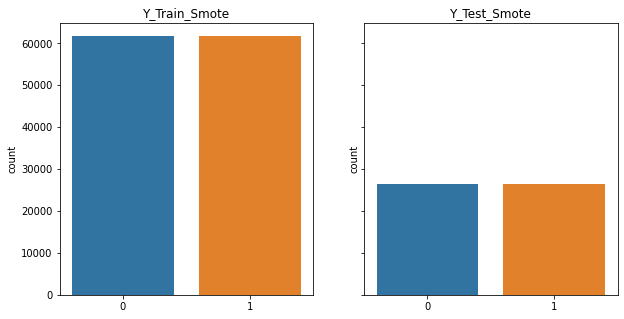

In [88]:
#plt.rcParams['figure.figsize']=5,5
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
#sns.countplot(df['Gender'],ax=axes[0])
sns.countplot(y_train_sm,ax=axes[0])
axes[0].set_title("Y_Train_Smote")

sns.countplot(y_test_sm,ax=axes[1])
axes[1].set_title("Y_Test_Smote")

Logistic Regression

In [89]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Run Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_sm, y_train_sm)
y_pred = logreg.predict(X_test_sm)

# Analyze results
print("Results:")
print("Accuracy", metrics.accuracy_score(y_test_sm,y_pred))

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test_sm, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",TN / float(TN + FP))

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",FP / float(TN + FP))

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision: Out of the ones our model said will not show up, how many didn't:",metrics.precision_score(y_test_sm, y_pred))

#Sensitivity:
print("Recall: Out of the ones that did not show up, how many did we predict correctly?:",metrics.recall_score(y_test_sm, y_pred))





Results:
Accuracy 0.954444066386904
Specificity: 0.9309666931306945
False Positive Rate: 0.0690333068693055
Precision: Out of the ones our model said will not show up, how many didn't: 0.9340627595421226
Recall: Out of the ones that did not show up, how many did we predict correctly?: 0.9779214396431137


In [90]:
# examine the class distribution of the testing set (using a Pandas Series method)
print("Class Distribution:", pd.Series(y_test_sm).value_counts())
# calculate the percentage of ones
print("Percentage of Ones:", y_test_sm.mean())

# calculate the percentage of zeros
print("Percentage of Zeros:", 1 - y_test_sm.mean())

# calculate null accuracy (for binary classification problems coded as 0/1)
print("Null Accuracy:",max(y_test_sm.mean(), 1 - y_test_sm.mean()))

Class Distribution: 1    26451
0    26451
dtype: int64
Percentage of Ones: 0.5
Percentage of Zeros: 0.5
Null Accuracy: 0.5


In [194]:
#Comparing the model with StatsModels
import statsmodels.api as sm
#logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
logm4 = sm.GLM(y_train_sm,(sm.add_constant(X_train_sm)), family = sm.families.Binomial())
modres = logm4.fit()
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               123512
Model:                            GLM   Df Residuals:                   123465
Model Family:                Binomial   Df Model:                           46
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 30 Jun 2021   Deviance:                          nan
Time:                        15:26:05   Pearson chi2:                 4.21e+19
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                            -3.007e+20   3.33e+13  -9.02e+06      0.000   -3.01e+20   -3.01e+20
Gender_M                          1.025e+14   4.18e+05   2.45e+08      0.000    1.03e+14    1.03e+14
comorbities_1                    -1.142e+14   4.63e+05  -2.47e+08      0.000   -1.14e+14   -1.14e+14
comorbities_2                      1.84e+13   1.64e+04   1.12e+09      0.000    1.84e+13    1.84e+13
is_weekend_1                      -2.06e+15   1.68e+07  -1.23e+08      0.000   -2.06e+15   -2.06e+15
Wait_days_Bins_(0, 1]             1.023e+13   9.87e+05   1.04e+07      0.000    1.02e+13    1.02e+13
Wait_days_Bins_(1, 2]             1.614e+14    7.1e+05   2.27e+08      0.000    1.61e+14    1.61e+14
Wait_days_Bins_(2, 3]             9.379e+13   1.34e+06   7.02e+07      0.000    9.38e+13    9.38e+13
Wait_days_Bins_(3, 7]             7.498e+14   6.95e+05   1.08e+09      0.000     7.5e+14     7.5e+14
Wait_days_Bins_(7, 14]            2.687e+14      5e+05   5.38e+08      0.000    2.69e+14    2.69e+14
Wait_days_Bins_(14, 30]           8.438e+14   6.52e+05    1.3e+09      0.000    8.44e+14    8.44e+14
Wait_days_Bins_(30, 60]           1.285e+14   7.02e+05   1.83e+08      0.000    1.29e+14    1.29e+14
Wait_days_Bins_(60, 90]           8.824e+14   1.56e+06   5.67e+08      0.000    8.82e+14    8.82e+14
Wait_days_Bins_(90, 1000]         3.134e+14   4.52e+06   6.93e+07      0.000    3.13e+14    3.13e+14
SMS_received_1                   -2.579e+13   4.62e+05  -5.58e+07      0.000   -2.58e+13   -2.58e+13
Alcoholism_1                     -3.405e+13   6.44e+05  -5.29e+07      0.000    -3.4e+13    -3.4e+13
Age_Bins_(0, 2]                     2.6e+13   1.62e+06    1.6e+07      0.000     2.6e+13     2.6e+13
Age_Bins_(2, 10]                  5.412e+13   1.33e+06   4.06e+07      0.000    5.41e+13    5.41e+13
Age_Bins_(10, 20]                 1.756e+14   1.31e+06   1.34e+08      0.000    1.76e+14    1.76e+14
Age_Bins_(20, 30]                -1.938e+14   1.22e+06  -1.59e+08      0.000   -1.94e+14   -1.94e+14
Age_Bins_(30, 40]                -4.307e+13    1.3e+06  -3.31e+07      0.000   -4.31e+13   -4.31e+13
Age_Bins_(40, 50]                -1.314e+13   1.31e+06  -1.01e+07      0.000   -1.31e+13   -1.31e+13
Age_Bins_(50, 60]                -2.322e+14   1.25e+06  -1.86e+08      0.000   -2.32e+14   -2.32e+14
Age_Bins_(60, 80]                 3.113e+13   1.31e+06   2.38e+07      0.000    3.11e+13    3.11e+13
Age_Bins_(80, 100]               -9.741e+12   1.78e+06  -5.48e+06      0.000   -9.74e+12   -9.74e+12
Age_Bins_(100, 200]               8.548e+13   1.63e+07   5.25e+06      0.000    8.55e+13    8.55e+13
Num_Prev_Appts_Missed_(0, 1]      2.946e+15   3.87e+05   7.61e+09      0.000    2.95e+15    2.95e+15
Num_Prev_Appts_Missed_(1, 2]      3.025e+15   8.06e+0

## RFE

In [195]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train_sm,y_train_sm)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)           # Printing the ranking

[False False False False False  True False  True  True  True  True  True
  True False False False False False False False False False False False
 False  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False]
[28 33 34  4  2  1  3  1  1  1  1  1  1  9 32 18 19  6 27 14 13 12 10 11
 15  1  1  1  1  1  1  1  1 30 35 36  7 31 25 24 21 22 23  5 16 37 29 26
 17  8 20]


In [196]:
rf=pd.DataFrame((zip(X_train_sm.columns,rfe.support_,rfe.ranking_)))
rf.columns=['col','support','rnk']
rf.loc[rf.rnk.isin([1,2,3]) ,['col']]

,col
4,"Wait_days_Bins_(0, 1]"
5,"Wait_days_Bins_(1, 2]"
6,"Wait_days_Bins_(2, 3]"
7,"Wait_days_Bins_(3, 7]"
8,"Wait_days_Bins_(7, 14]"
9,"Wait_days_Bins_(14, 30]"
10,"Wait_days_Bins_(30, 60]"
11,"Wait_days_Bins_(60, 90]"
12,"Wait_days_Bins_(90, 1000]"
25,"Num_Prev_Appts_Missed_(0, 1]"


In [200]:
cols=['Wait_days_Bins_(0, 1]',
'Wait_days_Bins_(1, 2]',
	'Wait_days_Bins_(2, 3]',
	'Wait_days_Bins_(3, 7]',
	'Wait_days_Bins_(7, 14]',
	'Wait_days_Bins_(14, 30]',
	'Wait_days_Bins_(30, 60]',
	'Wait_days_Bins_(60, 90]',
'Wait_days_Bins_(90, 1000]',
'Num_Prev_Appts_Missed_(0, 1]',
	'Num_Prev_Appts_Missed_(1, 2]',
	'Num_Prev_Appts_Missed_(2, 3]',
	'Num_Prev_Appts_Missed_(3, 4]',
	'Num_Prev_Appts_Missed_(4, 6]',
	'Num_Prev_Appts_Missed_(6, 9]',
	'Num_Prev_Appts_Missed_(9, 12]']


In [201]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

Apply logistic reg to columns selected by rfe

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
#logsk.fit(X_train[col], y_train)
logsk.fit(X_train_sm[cols], y_train_sm)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [203]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test_sm[cols])
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Let's see the head
y_pred_1.head()

,1
0,0.000101
1,0.000101
2,0.000101
3,0.001069
4,0.000680


In [204]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test_sm)
y_test_df=y_test_df.rename({0: 'Actual'}, axis=1)

y_test_df['PatientId']=X_test_sm.index
y_test_df.set_index('PatientId',inplace=True)
y_test_df.head()

,Actual
PatientId,
9.656774e+14,0
6.291782e+13,0
9.447489e+13,0
7.271114e+09,0
8.525612e+13,0


In [205]:
# Putting CustID to index
y_test_df['PatientID'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Predicted_Prob'})
# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['PatientID','Actual','Predicted_Prob'], axis=1)
# Let's see the head of y_pred_final
y_pred_final=y_pred_final[['PatientID','Actual','Predicted_Prob']]
y_pred_final.head()

,PatientID,Actual,Predicted_Prob
0,9.656774e+14,0,0.000101
1,6.291782e+13,0,0.000101
2,9.447489e+13,0,0.000101
3,7.271114e+09,0,0.001069
4,8.525612e+13,0,0.000680


In [206]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Predicted_Prob.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

,PatientID,Actual,Predicted_Prob,predicted
0,9.656774e+14,0,0.000101,0
1,6.291782e+13,0,0.000101,0
2,9.447489e+13,0,0.000101,0
3,7.271114e+09,0,0.001069,0
4,8.525612e+13,0,0.000680,0


Accuracy Score

In [207]:
from sklearn import metrics
#Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final['Actual'], y_pred_final.predicted)

0.9373747684397565

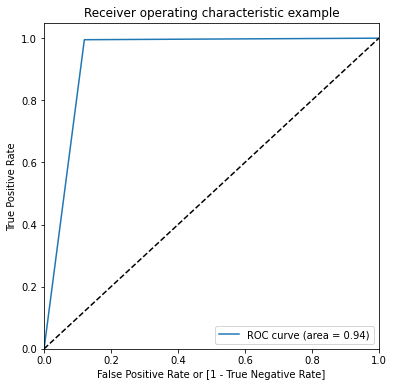

(array([0.        , 0.12029791, 1.        ]),
 array([0.        , 0.99504745, 1.        ]),
 array([2, 1, 0]))

In [208]:
draw_roc(y_pred_final.Actual, y_pred_final.predicted)

Random Forest

In [91]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
# Running the random forest with default parameters.
rfc = RandomForestClassifier()
rfc.fit(X_train_sm,y_train_sm)
# Making predictions
predictions = rfc.predict(X_test_sm)
pred_prob = rfc.predict_proba(X_test_sm)

train_pred=rfc.predict(X_train_sm)
train_pred_prob=rfc.predict_proba(X_train_sm)

In [92]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print(classification_report(y_test_sm,predictions))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96     26451
           1       0.96      0.96      0.96     26451

    accuracy                           0.96     52902
   macro avg       0.96      0.96      0.96     52902
weighted avg       0.96      0.96      0.96     52902



In [93]:
print(confusion_matrix(y_test_sm,predictions))

[[25342  1109]
 [ 1002 25449]]


In [94]:
accuracy_train =accuracy_score(y_train_sm,train_pred)
print("Accuracy train : %.2f%%" % (accuracy_train * 100.0))

accuracy=accuracy_score(y_test_sm,predictions)
print("Accuracy test : %.2f%%" % (accuracy * 100.0))



Accuracy train : 98.77%
Accuracy test : 96.01%


In [95]:
print("Accuracy", 100*(metrics.accuracy_score(y_test_sm,predictions)))

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test_sm, predictions)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",(TN / float(TN + FP))*100)

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",(FP / float(TN + FP))*100)

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision: Out of the ones our model said will not show up, how many didn't:",(metrics.precision_score(y_test_sm, predictions))*100)

#Sensitivity:
print("Recall: Out of the ones that did not show up, how many did we predict correctly?:",(metrics.recall_score(y_test_sm, predictions))*100)


Accuracy 96.00960266152508
Specificity: 95.80734187743374
False Positive Rate: 4.192658122566255
Precision: Out of the ones our model said will not show up, how many didn't: 95.82423375254162
Recall: Out of the ones that did not show up, how many did we predict correctly?: 96.21186344561642


In [96]:
pred_prob=pd.DataFrame(pred_prob)

In [97]:

rndm_eval=pd.DataFrame()
rndm_eval['patid']=X_test_sm.index
rndm_eval['predictions']=predictions
rndm_eval['Actual']=y_test_sm
rndm_eval=pd.concat([rndm_eval,pred_prob[1]],axis=1)
rndm_eval=rndm_eval.rename({1:'Predict_Prob'},axis=1)
rndm_eval[predictions==1].head(10)

,patid,predictions,Actual,Predict_Prob
5,7.458785e+12,1,1,0.990000
19,6.251637e+13,1,1,0.779071
27,4.341394e+14,1,1,1.000000
32,9.298734e+13,1,1,1.000000
36,1.316279e+13,1,1,0.960000
39,3.932552e+12,1,1,1.000000
40,3.469257e+13,1,0,0.755000
50,7.667828e+11,1,1,0.821000
51,5.834625e+14,1,0,0.760000
62,1.367427e+13,1,1,0.760000


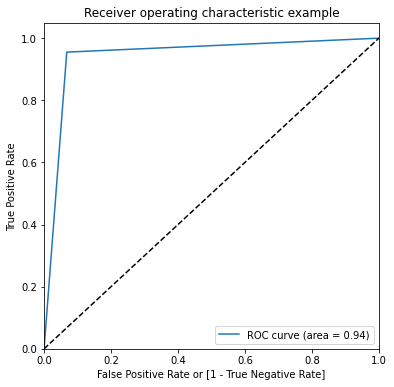

(array([0.        , 0.06774791, 1.        ]),
 array([0.        , 0.95512457, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [216]:
draw_roc(rndm_eval.Actual, rndm_eval.predictions)

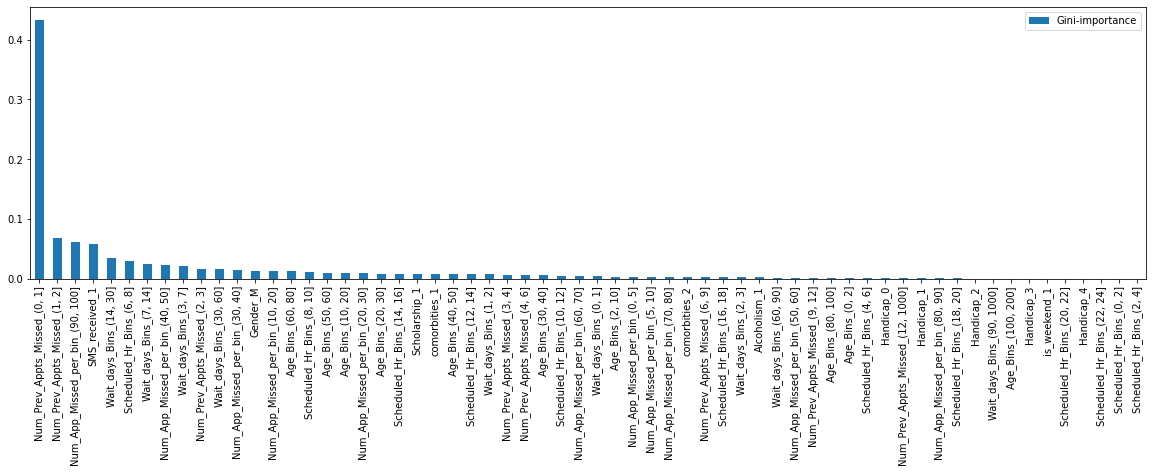

In [98]:
plt.rcParams['figure.figsize']=20,5
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_sm.columns, rfc.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',ascending=False).plot(kind='bar', rot=90)

In [223]:
importances.sort_values(by='Gini-importance',ascending=False).head(10)

,Gini-importance
"Num_Prev_Appts_Missed_(0, 1]",0.478970
"Num_Prev_Appts_Missed_(1, 2]",0.095512
"Scheduled_Hr_Bins_(12, 14]",0.044329
"Num_Prev_Appts_Missed_(2, 3]",0.034105
"Num_Prev_Appts_Missed_(3, 4]",0.029285
"Scheduled_Hr_Bins_(6, 8]",0.028690
"Num_Prev_Appts_Missed_(4, 6]",0.026462
"Wait_days_Bins_(14, 30]",0.025515
"Wait_days_Bins_(7, 14]",0.023058
"Wait_days_Bins_(3, 7]",0.022593


## XGBoost

In [219]:
from sklearn import metrics
from xgboost import XGBClassifier
import re
model = XGBClassifier()

X_train_sm_xgb=X_train_sm.copy()
X_test_sm_xgb=X_test_sm.copy()
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train_sm_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_sm.columns.values]
X_test_sm_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_sm.columns.values]

model.fit(X_train_sm_xgb,y_train_sm)
y_pred = model.predict(X_test_sm_xgb)
predictions = [round(value) for value in y_pred]
accuracy = metrics.accuracy_score(y_test_sm, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 94.03%


In [221]:
print("Accuracy", 100*(metrics.accuracy_score(y_test_sm,predictions)))

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test_sm, predictions)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

#Specificity: When the actual value is negative, how often is the prediction correct?
print("Specificity:",(TN / float(TN + FP))*100)

#False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
print("False Positive Rate:",(FP / float(TN + FP))*100)

#Precision: When a positive value is predicted, how often is the prediction correct?
print("Precision: Out of the ones our model said will not show up, how many didn't:",(metrics.precision_score(y_test_sm, predictions))*100)

#Sensitivity:
print("Recall: Out of the ones that did not show up, how many did we predict correctly?:",(metrics.recall_score(y_test_sm, predictions))*100)

Accuracy 94.02858115005104
Specificity: 89.32743563570375
False Positive Rate: 10.672564364296246
Precision: Out of the ones our model said will not show up, how many didn't: 90.24466099937798
Recall: Out of the ones that did not show up, how many did we predict correctly?: 98.72972666439833


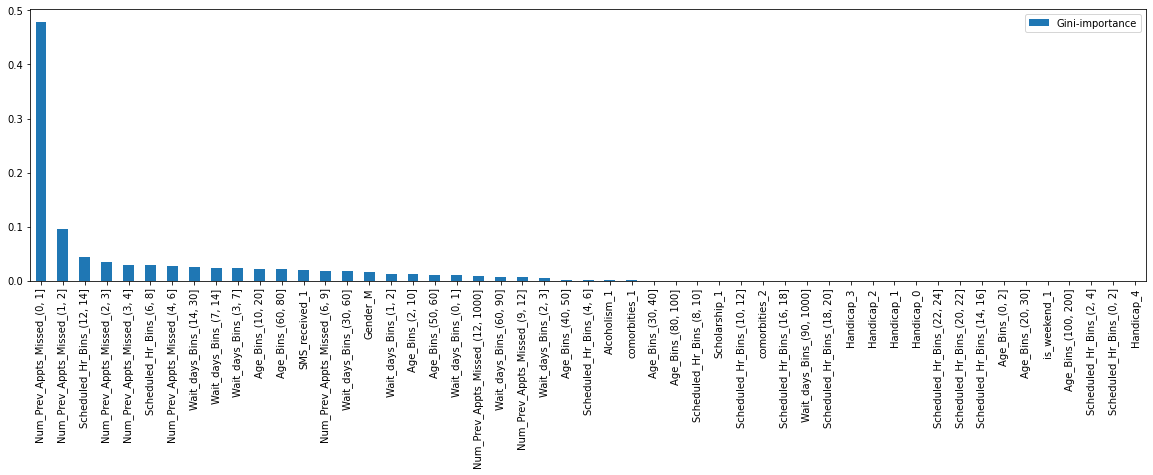

In [222]:
plt.rcParams['figure.figsize']=20,5
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_sm.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',ascending=False).plot(kind='bar', rot=90)

In [ ]:
final_cols=['Num_Prev_Appts_Missed_(0, 3]','SMS_received_1',	'Scheduled_Hr_Bins_(6, 8]','Wait_days_Bins_(3, 6]','Gender_M','Age_Bins_(60, 80]']


#### Doing visualizations on these: 

In [ ]:
df.loc(Num_Prev_Appts_Missed)
#df.groupby(h)['No-show'].mean()

In [ ]:
plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x="Num_Prev_Appts_Missed", data=df )

In [ ]:
sns.countplot(df['Num_Prev_Appts_Missed']/)

Compare No SHow vs SMS Recieved

In [ ]:
plt.rcParams['figure.figsize']=5,5
sns.barplot(y="No-show", x="SMS_received", data=df )





In [ ]:
sns.countplot(df['SMS_received'])

Scheduled Hr Bins

In [ ]:
plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x="Scheduled_Hr_Bins", data=df )

In [ ]:
plt.rcParams['figure.figsize']=20,5
sns.countplot(df['Scheduled_Hr_Bins'])

Wait Days

In [ ]:
plt.rcParams['figure.figsize']=20,5
sns.barplot(y="No-show", x="Wait_day_Bins", data=df )

In [ ]:
plt.rcParams['figure.figsize']=20,5
sns.countplot(df['Scheduled_Hr_Bins'])

In [ ]:
df.groupby(h)['No-show'].mean()

## Class Distribution
The null accuracy is ~ 80%, which means that if there is no model, and we 'naivly' predict that everyone will show up, we will be right 80 % of the time. That means the model needs to do better than this base accuracy in order to be useful.

In [ ]:
# examine the class distribution of the testing set (using a Pandas Series method)
print("Class Distribution:", y_test.value_counts())
# calculate the percentage of ones
print("Percentage of Ones:", y_test.mean())

# calculate the percentage of zeros
print("Percentage of Zeros:", 1 - y_test.mean())

# calculate null accuracy (for binary classification problems coded as 0/1)
print("Null Accuracy:",max(y_test.mean(), 1 - y_test.mean()))

The Logistic Regression model is 89.88 % accuracate on the test set, which is an improvement of 9.88% better than a naive model. 

Recall: Out of the ones that did not show up, how many did we predict correctly? 50 %

Precision: Out of the ones our model said will not show up, how many didn't ? 72 %



The model is 92 % accuracate on the test set, which is an improvement of 12% better than a naive model.

Recall: Out of the ones that did not show up, how many did we predict correctly? 88 %

Precision: Out of the ones our model said will not show up, how many didn't ? 75 %

To determine which metric to use, we need to do a cost-benefit analysis. 
Implications:
True Positive: Model says patient wil not show up, and they don't
False Positive: Model says patient will not show up, but they do
True Negative: Model says patient will show up, and they do
False Negative: Model says a patient will show up, but they don't

To determine which metric to use, we need to do a cost-benefit analysis. 
If we say a patient will not show up, but they do, the office would be booked and patients will have to wait and they will get upset. If we say a patient will show up, but they don't then the doctor's office will lose money because another patient could have been served at that time. 

Based on domain knowledge and past experiences, the office would rather overbook than have empty time in their schedule. Therefore, recall is the metric they care about, and based on recall, the decision tree clasifier performed the best at 88%. 

## Most important features

In [ ]:
import matplotlib.pyplot as plt
n_features = X_train1.shape[1]
plt.barh(range(n_features), tree.feature_importances_, )
plt.yticks(np.arange(n_features), X_train1)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

Most important features are:
    - Age of the patient
    - WaitingTime (how long in advanced was appointment scheduled)
    - Number of appointments missed in the past
    


## Explore Important Features 
## Age

In [ ]:
bins = [0, 20, 40, 60, 100]
age_groups = df.groupby(pd.cut(df.Age, bins))
age_groups["No-show"].mean()


## Awaiting Time


In [ ]:
bins = [0,1,7, 180]
wait_time = df.groupby(pd.cut(df.AwaitingTime, bins))
wait_time["No-show"].mean()

People who scheduled 1 day or less in advance of their appointment, did not show up only 6.6 % of the time. Those that scheduled more than 1 day but less than 1 week in advance, did not show up 25 % of the time, and those who scheduled more than 2 weeks in advance did not show up more than 30% of the time.The results did not surprise me. Based on my experience, when I schedule an appointment too far in advance, I either forget to go to it if I'm not remided, or I feel better by the time the appointment comes and don't go.